In [1]:
from bs4 import BeautifulSoup
import requests
import zipfile
from datetime import datetime
from io import StringIO,BytesIO
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import bokeh

In [3]:
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Confirm node information

In [4]:
start='20190101T08:00-0000'
end='20190201T08:00-0000'

def node_list(start,end,market='DAM'):
    source='http://oasis.caiso.com/oasisapi/SingleZip?resultformat=6&queryname=ATL_PNODE&Pnode_type=ALL&version=1&startdatetime='
    source+=start+'&enddatetime='+end+'&Pnode_id=ALL&CB_NODE_FLAG=ALL'
    r = requests.get(source, stream=True)
    z = zipfile.ZipFile(BytesIO(r.content))
    unzipped = [z.read(thisfile) for thisfile in z.namelist()]
    s = unzipped[0]
    l = s.decode("utf-8") 
    #print(l)
    l=l.replace('\n',',')
    l=l.split(',')[:-1]
    L = np.array(l).reshape(int(len(l)/14),14)
    nodes = L[1:,0]
    return nodes

In [5]:
nodes = node_list(start,end)

In [6]:
df=pd.read_csv('LMP_coordinates.csv')

In [7]:
l_nodes=np.array(df['node_id'].values,dtype=str)

In [8]:
common_nodes=np.intersect1d(l_nodes,nodes)
len(common_nodes),len(l_nodes)

(6384, 6395)

In [9]:
ind = (df['longitude']>-1e9)&(df['longitude']<0)&(df['latitude']>30)&(df['latitude']<50)
df = df[ind]

Code below is used to retrieve monthly data for ~6000 Pnodes

In [11]:
import time
D_L=['20180301T08:00-0000','20180401T08:00-0000','20180501T08:00-0000','20180515T08:00-0000','20180601T08:00-0000',
     '20180701T08:00-0000','20180715T08:00-0000','20180801T08:00-0000',
     '20180815T08:00-0000','20180901T08:00-0000','20181001T08:00-0000','20181015T08:00-0000','20181101T08:00-0000','20181201T08:00-0000',
     '20190101T08:00-0000','20190201T08:00-0000','20190301T08:00-0000','20190327T08:00-0000']


Pnodes = df['node_id'].values
def price_h(start,end,nodes,Dict,market='DAM'):
    base='http://oasis.caiso.com/oasisapi/SingleZip?resultformat=6&'
    dataset='PRC_LMP'
    start_date = datetime(int(start[:4]),int(start[4:6]),int(start[6:8]),int(start[9:11]),int(start[12:14]))
    end_date = datetime(int(end[:4]),int(end[4:6]),int(end[6:8]),int(end[9:11]),int(end[12:14]))
    source = base+'queryname='+dataset+'&version=1&startdatetime='+start+'&enddatetime='+end+'&market_run_id='+market+'&node='
    Nodes = ','.join(nodes)
    #Dict = {}  
    try:
        r = requests.get(source+Nodes)
        z = zipfile.ZipFile(BytesIO(r.content))
        unzipped = [z.read(thisfile) for thisfile in z.namelist()]
        s = unzipped[0]
        l = s.decode("utf-8") 
        l=l.replace('\n',',')
        l=l.split(',')[:-1]
        L = np.array(l).reshape(int(len(l)/16),16)
        #print(L)
    except:
        return Dict
    for i in range(len(nodes)):
        
            ind_lmp = (L[:,9]=='LMP')*(L[:,5]==nodes[i])
                    #ind_mce = (L[:,8]=='MCE')
            times = L[ind_lmp,0]
            dates_list = np.array([datetime.strptime(date, '%Y-%m-%dT%H:%M:%S-00:00') for date in times])
            #print(dates_list)
            price_lmp = L[ind_lmp,14][dates_list.argsort()]
            
            Dict.update({nodes[i]:price_lmp.astype(float)}) 

                #print(Dict)
            

    Dict['Timestamp']=dates_list[dates_list.argsort()]
    
    #df = pd.DataFrame(data=Dict)
    return Dict

The cell below runs a loop to download all the data and store into a list of dictionaries.

In [ ]:
import time

start_time = time.time()
D_List=[]
for j in range(len(D_L)):
    Dict={}
    start=D_L[j]
    end=D_L[j+1]
    for i in range(631):
        Dict=price_h(start,end,Pnodes[i*10:(i+1)*10],Dict)
        time.sleep(5)
    D_List.append(Dict)

end_time = time.time()

elapsed = end_time - start_time


In [ ]:
elapsed

The cell below process the raw data into pandas Data Frames and saves each dataframe into csv files.

In [16]:
for i in range(len(D_L)):
    
    try:
        Dict_=D_List[i]
        Cleaned_dict = {}
        Cleaned_dict['Timestamp']=Dict_['Timestamp']
        for e in Dict_.keys():
            if len(Dict_[e])==len(Dict_['Timestamp']) and e!='Timestamp':
                Cleaned_dict[e]=Dict_[e]
        Df = pd.DataFrame(data=Cleaned_dict)
        Df=Df.sort_values(by=['Timestamp'])
        Df.to_csv(D_L[i][:8]+'_hourly_prices.csv',index=False)
    except:
        print(i)
        

In [31]:

def plot_price(node):
    plt.figure(figsize=(20,10))
    

    
    plt.plot(Df['Timestamp'],Df[node],'k')
    plt.title(node)
    plt.xlabel('Time')
    plt.ylabel('LMP')

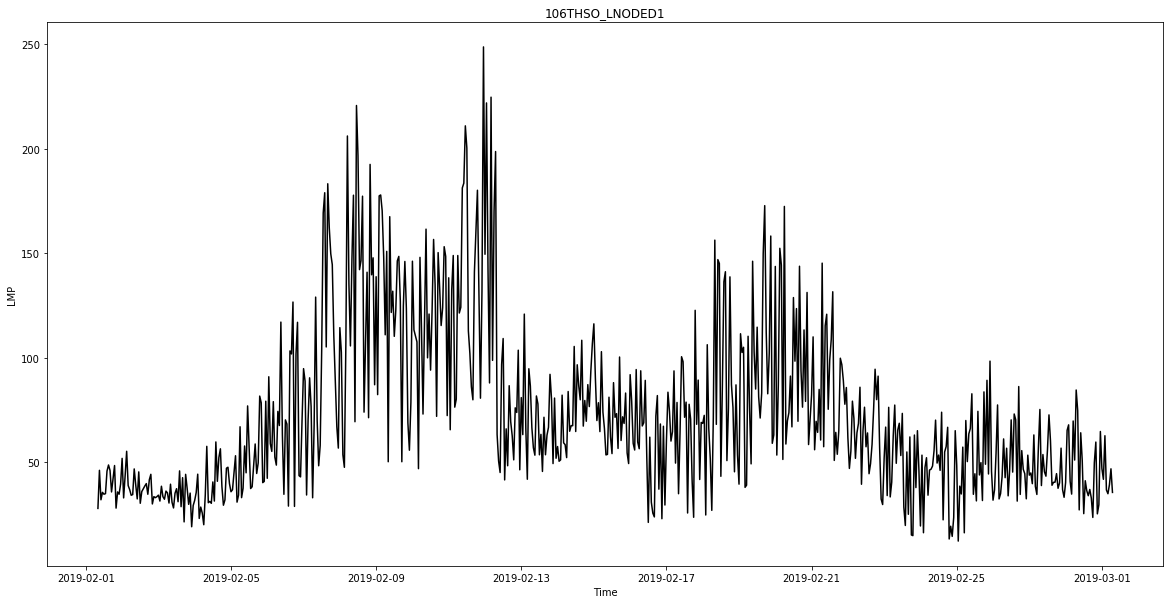

In [35]:
plot_price('106THSO_LNODED1')